In [ ]:
pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 4.1 MB/s eta 0:00:00


In [ ]:
import osmnx as ox
import networkx as nx
import folium
import numpy as np
import datetime
import math

# --- Global Configuration ---
ox.settings.log_console = True
ox.settings.use_cache = True

# Define a constant speed (30 km/h) for the final time estimate.
AVG_DRIVING_SPEED_MPS = 30000 / 3600
# Optimization criterion: shortest path routing by 'length' (distance).
DISTANCE_WEIGHT = "length"

# Landmark Data for the Bursa Tour
LANDMARKS = [
    ("Ulu Camii", 40.18427505098681, 29.061943615457412),
    ("Koza Han", 40.18484880652651, 29.06353148314309),
    ("Tophane Saat Kulesi", 40.18781586493572, 29.057619894763597),
    ("Lunapark", 40.198594535963366, 29.045725587180673),
    ("Muradiye Külliyesi", 40.19121716736091, 29.046222989476252),
    ("Saltanat Kapısı", 40.18629956679333, 29.058067624597292),
    ("Irgandı Köprüsü", 40.18266031289346, 29.07081348157587),
    ("Hünkar Köşkü", 40.174823779117055, 29.065105741139103),
    ("Panorama 1326 Bursa Fetih Müzesi", 40.18670181066609, 29.075553295914325)
]

LANDMARK_NAMES = [l[0] for l in LANDMARKS]
LANDMARK_COORDS = [(l[1], l[2]) for l in LANDMARKS]
N = len(LANDMARKS)


# Core Functions for Routing and TSP

def download_and_prepare_network(place):
    """Downloads the street network as a directed graph ('drive') to enforce one-way traffic rules, and finds the nearest graph node for each landmark."""
    print("Fetching Bursa street network (Osmangazi district)...")
    G = ox.graph_from_place(place, network_type="drive")

    orig_nodes = []
    for lat, lon in LANDMARK_COORDS:
        node = ox.nearest_nodes(G, lon, lat)
        orig_nodes.append(node)

    return G, orig_nodes

def calculate_distance_matrix(G, orig_nodes):
    """Calculates the shortest driving distance between all landmark pairs for use as the TSP cost matrix."""
    print("Calculating all-pairs shortest path distance matrix...")

    dist_matrix = np.zeros((N, N))

    for i in range(N):
        try:
            lengths = nx.shortest_path_length(G, source=orig_nodes[i], weight=DISTANCE_WEIGHT)
            for j in range(N):
                if i != j and orig_nodes[j] in lengths:
                    dist_matrix[i, j] = lengths[orig_nodes[j]]
                elif i != j:
                    dist_matrix[i, j] = np.inf
        except nx.NetworkXNoPath:
            dist_matrix[i, :] = np.inf

    return dist_matrix

def greedy_insertion_tsp(cost_matrix, start_index=0):
    """Applies the Greedy Insertion heuristic to find an efficient solution to the Traveling Salesperson Problem (TSP)."""
    N_mat = cost_matrix.shape[0]

    unreachable_nodes = [i for i in range(N_mat) if np.all(cost_matrix[i, :] == np.inf) and i != start_index]

    unvisited = set(i for i in range(N_mat) if i not in unreachable_nodes)
    unvisited.remove(start_index)

    if not unvisited:
        return [start_index]

    # Initialize tour: start -> closest neighbor -> start.
    temp_distances = cost_matrix[start_index, list(unvisited)]
    if np.all(temp_distances == np.inf):
        print(f"Warning: Starting landmark is isolated.")
        return [start_index]

    closest_neighbor_idx_in_subset = np.argmin(temp_distances)
    neighbor_index = list(unvisited)[closest_neighbor_idx_in_subset]

    tour = [start_index, neighbor_index, start_index]
    unvisited.remove(neighbor_index)

    # Iteratively insert the best node based on minimal cost increase.
    while unvisited:
        best_cost = np.inf
        best_node = -1
        best_position = -1

        for k in unvisited:
            for i in range(len(tour) - 1):
                node_i = tour[i]
                node_j = tour[i+1]

                # Insertion cost calculation: Cost(i->k) + Cost(k->j) - Cost(i->j)
                cost = cost_matrix[node_i, k] + cost_matrix[k, node_j] - cost_matrix[node_i, node_j]

                if cost < best_cost:
                    best_cost = cost
                    best_node = k
                    best_position = i + 1

        if best_node == -1 or best_cost == np.inf:
            print(f"Warning: No valid insertion point found for remaining nodes. Stopping.")
            break

        tour.insert(best_position, best_node)
        unvisited.remove(best_node)

    return tour


# Main Application Execution

G, orig_nodes = download_and_prepare_network("Osmangazi, Bursa, Türkiye")

distance_matrix = calculate_distance_matrix(G, orig_nodes)

print("Solving the TSP to minimize the total driving distance...")
tsp_tour_indices = greedy_insertion_tsp(distance_matrix, start_index=0)

tsp_tour_nodes = [orig_nodes[i] for i in tsp_tour_indices]
tsp_tour_names = [LANDMARK_NAMES[i] for i in tsp_tour_indices]

print("\nCalculating full street-level routes and total distance...")
full_path_nodes = []
total_tour_length = 0

for i in range(len(tsp_tour_nodes) - 1):
    start_node = tsp_tour_nodes[i]
    end_node = tsp_tour_nodes[i+1]

    try:
        # Find the detailed shortest path for the segment.
        route = ox.shortest_path(G, start_node, end_node, weight=DISTANCE_WEIGHT)
        route_length = nx.path_weight(G, route, weight='length')

        total_tour_length += route_length

        # Extend the path, avoiding duplication of the junction node.
        if i == 0:
            full_path_nodes.extend(route)
        else:
            full_path_nodes.extend(route[1:])

        print(f"Segment {i+1}: {LANDMARK_NAMES[tsp_tour_indices[i]]} -> {LANDMARK_NAMES[tsp_tour_indices[i+1]]} ({route_length/1000:.2f} km)")

    except nx.NetworkXNoPath:
        print(f"🚨 Warning: No path found between {LANDMARK_NAMES[tsp_tour_indices[i]]} and {LANDMARK_NAMES[tsp_tour_indices[i+1]]}. Skipping segment.")

# Display final statistics
total_time_seconds = total_tour_length / AVG_DRIVING_SPEED_MPS
total_time_formatted = str(datetime.timedelta(seconds=round(total_time_seconds)))

print("\nOptimized TSP Tour Results")
print("Optimization Metric: Minimum Total Driving Distance")
print("Route Sequence:", ' -> '.join(tsp_tour_names))
print(f"Total stops (including return to start): {len(tsp_tour_names) - 1}")
print(f"Total estimated distance: **{total_tour_length/1000:.2f} km**")
print(f"Estimated duration (at 30 km/h): **{total_time_formatted}**")


# Visualization Function

def visualize_tour(G, full_path_nodes, tsp_tour_indices, total_tour_length, total_time_formatted):
    """Generates an interactive Folium map of the route with numbered markers and a summary panel."""

    if not full_path_nodes:
        print("\n❌ Visualization skipped: Route data is empty.")
        return

    # Convert graph nodes to (lat, lon) coordinates.
    route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in full_path_nodes]

    # Initialize map centered on the tour area.
    center_lat = 40.180
    center_lon = 29.070
    m = folium.Map(location=[center_lat, center_lon], zoom_start=13, tiles="OpenStreetMap")

    # Draw the continuous route path.
    folium.PolyLine(
        locations=route_coords,
        color='red',
        weight=4,
        opacity=0.9,
        tooltip=f"Total Distance: {total_tour_length/1000:.2f} km | Est. Time: {total_time_formatted}"
    ).add_to(m)

    # Map landmark index to its order in the optimized tour (1, 2, 3, ...).
    tour_order_map = {index: order + 1 for order, index in enumerate(tsp_tour_indices[:-1])}

    # Place numbered markers for the stops.
    for i, name in enumerate(LANDMARK_NAMES):
        if i in tour_order_map:
            order = tour_order_map[i]
            lat, lon = LANDMARK_COORDS[i]

            # Use a custom HTML icon for distinct stop numbering.
            icon = folium.features.DivIcon(
                icon_size=(30, 30),
                icon_anchor=(15, 15),
                html=f'<div style="font-size: 14pt; color: white; background-color: #007bff; border-radius: 50%; width: 30px; height: 30px; text-align: center; line-height: 30px; font-weight: bold;">{order}</div>'
            )

            folium.Marker(
                location=[lat, lon],
                popup=f'**Stop {order}:** {name}',
                icon=icon
            ).add_to(m)

    # Embed a summary box onto the map.
    html_summary = f"""
        <div style="
            position: fixed;
            bottom: 50px; left: 50px; width: 320px; height: 130px;
            border:2px solid #007bff; z-index:9999; font-size:14px;
            background-color:white; opacity: 0.95; padding:10px; border-radius: 8px;
            box-shadow: 2px 2px 5px rgba(0,0,0,0.2);
        ">
          <h4 style="margin-top:0; color:#007bff;">📍 Bursa TSP Tour Summary (Min Distance)</h4>
          <ul style="list-style-type: none; padding: 0;">
            <li style="margin-bottom: 5px;">Total Distance: <span style="font-weight: bold;">{total_tour_length/1000:.2f} km</span></li>
            <li style="margin-bottom: 5px;">Est. Duration: <span style="font-weight: bold;">{total_time_formatted}</span></li>
            <li>Number of Stops: {len(tsp_tour_indices) - 1}</li>
          </ul>
        </div>
    """
    m.get_root().html.add_child(folium.Element(html_summary))


    map_filename = "Bursa_tsp_min_distance_final_map.html"
    m.save(map_filename)
    print(f"\n✅ Interactive map successfully generated and saved as {map_filename}.")

# Execute visualization
visualize_tour(G, full_path_nodes, tsp_tour_indices, total_tour_length, total_time_formatted)

Fetching Bursa street network (Osmangazi district)...
Calculating all-pairs shortest path distance matrix...
Solving the TSP to minimize the total driving distance...

Calculating full street-level routes and total distance...
Segment 1: Ulu Camii -> Muradiye Külliyesi (2.49 km)
Segment 2: Muradiye Külliyesi -> Lunapark (1.82 km)
Segment 3: Lunapark -> Tophane Saat Kulesi (1.86 km)
Segment 4: Tophane Saat Kulesi -> Koza Han (0.83 km)
Segment 5: Koza Han -> Panorama 1326 Bursa Fetih Müzesi (1.44 km)
Segment 6: Panorama 1326 Bursa Fetih Müzesi -> Irgandı Köprüsü (1.20 km)
Segment 7: Irgandı Köprüsü -> Hünkar Köşkü (1.32 km)
Segment 8: Hünkar Köşkü -> Saltanat Kapısı (1.54 km)
Segment 9: Saltanat Kapısı -> Ulu Camii (0.49 km)

Optimized TSP Tour Results
Optimization Metric: Minimum Total Driving Distance
Route Sequence: Ulu Camii -> Muradiye Külliyesi -> Lunapark -> Tophane Saat Kulesi -> Koza Han -> Panorama 1326 Bursa Fetih Müzesi -> Irgandı Köprüsü -> Hünkar Köşkü -> Saltanat Kapısı ->

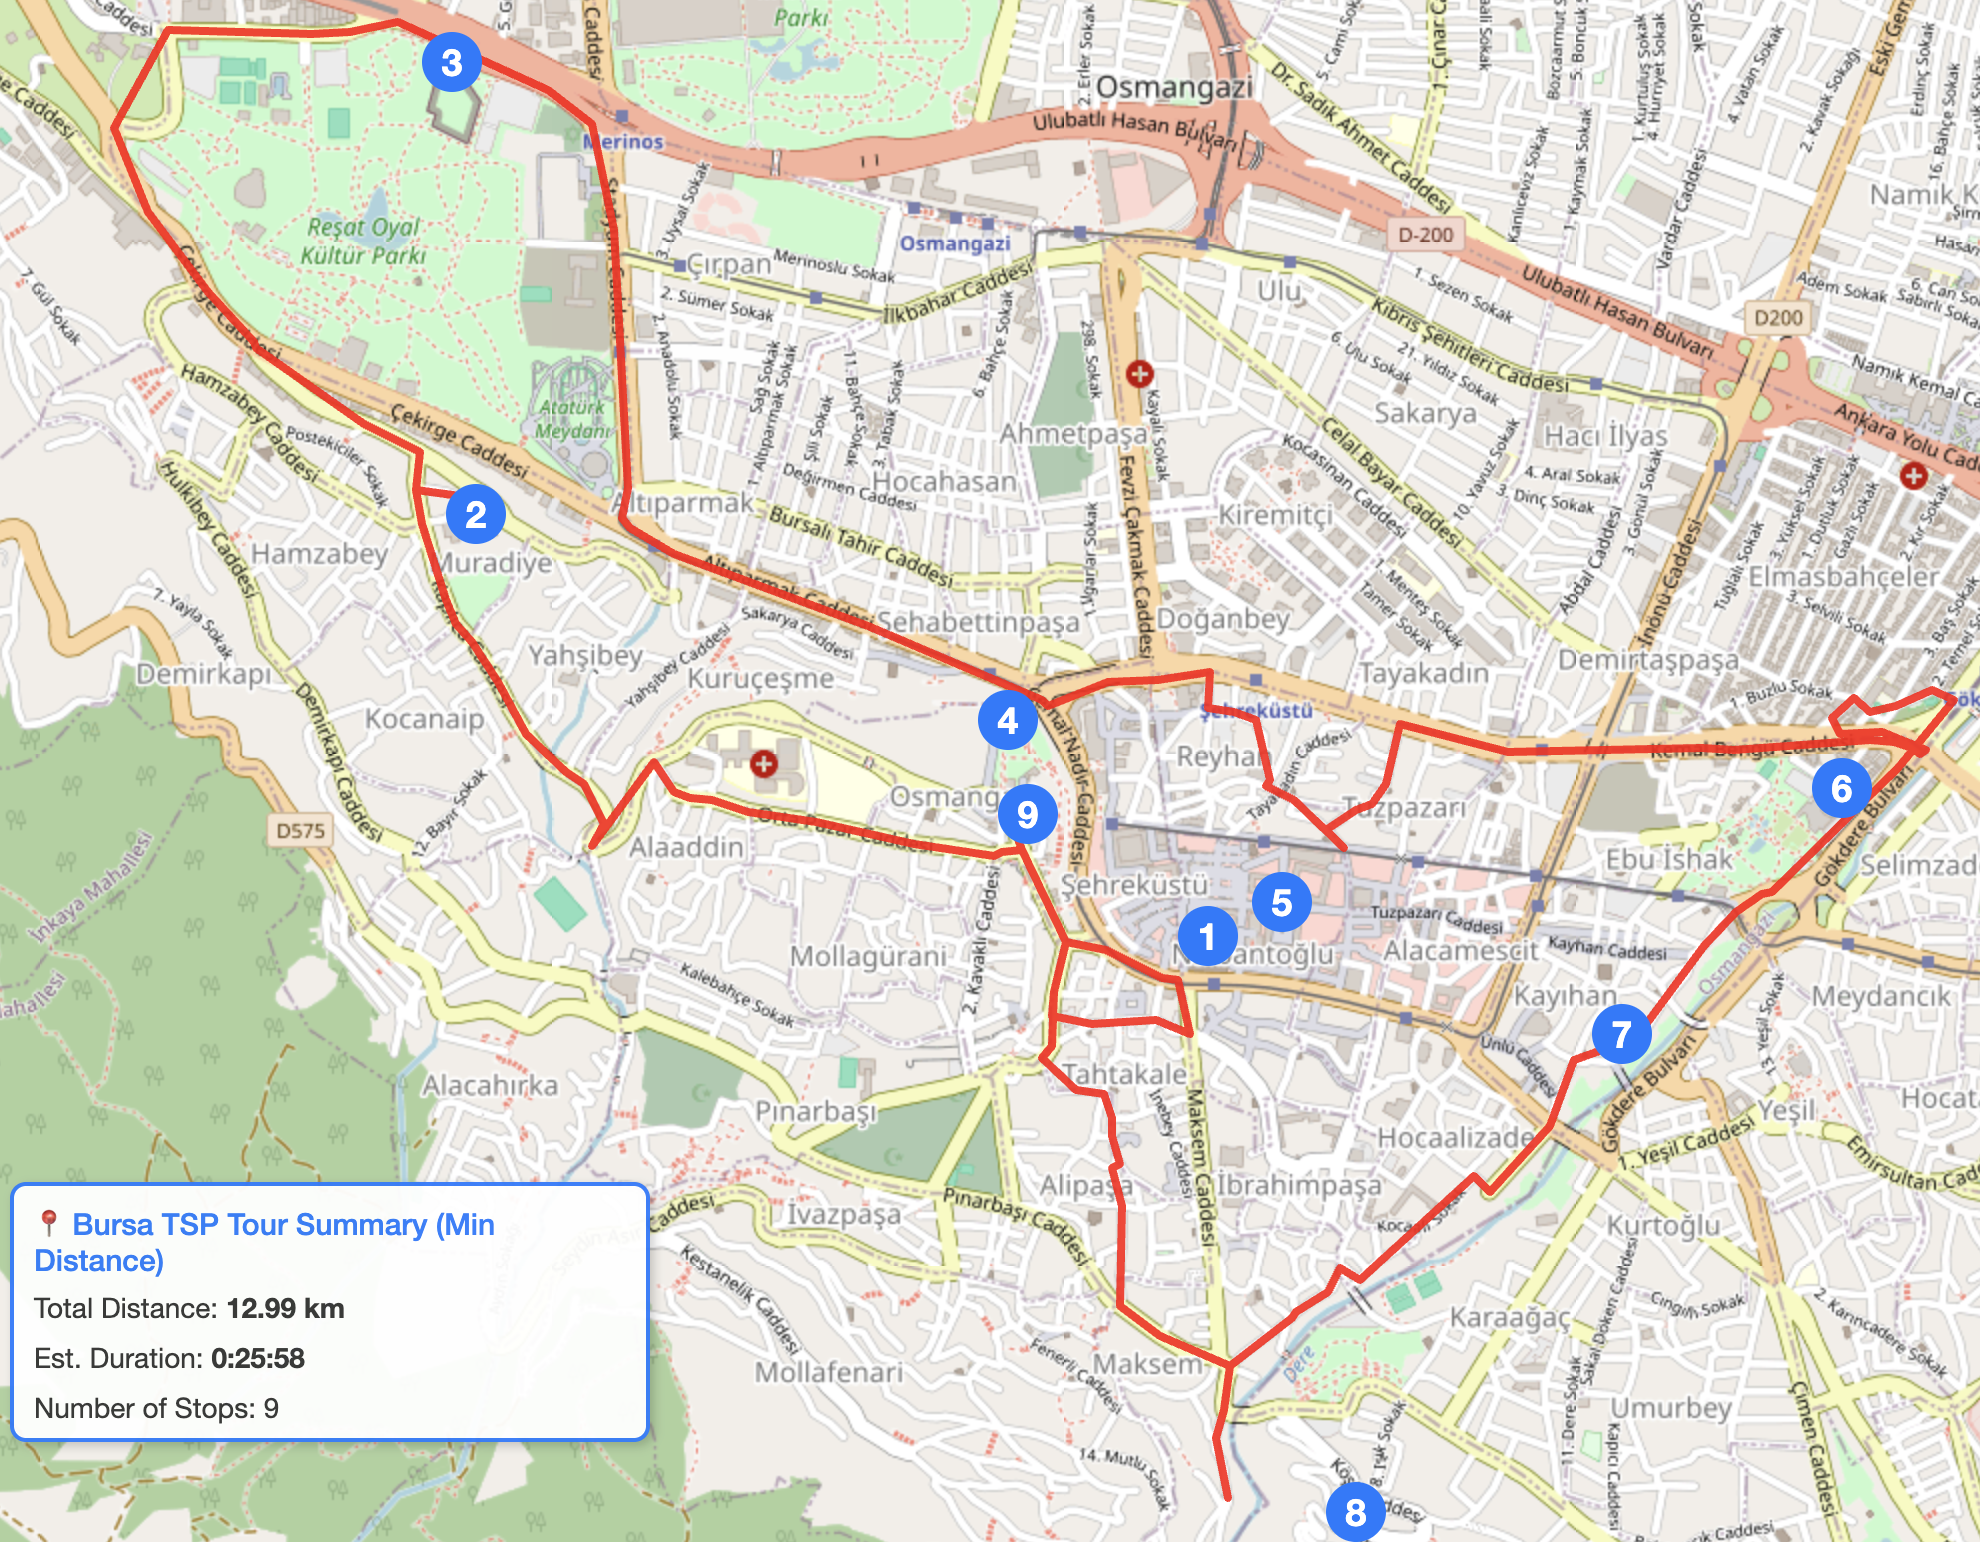

# Summary of the Code's Operation: Bursa TSP Tour

The Python script effectively solves a **real-world Traveling Salesperson Problem (TSP)** using **Geographic Information Systems (GIS)** libraries — specifically `osmnx` and `networkx` — before **visualizing** the results with **Folium**.

---

## I. Data Acquisition and Network Preparation

- **Landmark Definition**  
  Nine key tourist attractions in Bursa are defined with **precise geographical coordinates** to serve as the **TSP nodes**.

- **Network Download**  
  The **street network** for the **Osmangazi, Bursa** region is downloaded from **OpenStreetMap**.  
  The `network_type="drive"` setting ensures a **directed graph** is used, accurately modeling real-world constraints like **one-way streets**.

- **Node Mapping**  
  Each landmark’s coordinates are **precisely mapped** to the **nearest available road junction (node)** within the downloaded street network, ensuring the route **begins and ends on valid roads**.

---

## II. TSP Solving and Route Calculation

- **Cost Matrix Generation**  
  A **full-fledged cost matrix** is calculated by finding the **shortest driving distance** between every possible pair of landmark nodes.  
  Distances are computed using **Dijkstra’s algorithm** (via `networkx`) with **road segment lengths** as weights.

- **Heuristic Optimization**  
  The **Greedy Insertion heuristic** is applied to the cost matrix.  
  This method determines the **optimal sequence** of visiting the 9 landmarks (**starting and ending at Ulu Camii**) that results in the **absolute minimum cumulative driving distance**.

- **Final Route Detailing**  
  The script calculates the **exact, street-level path** for each segment of the optimized sequence.  
  It then **sums up the lengths** of all segments to provide the **final Total Driving Distance**.

---

## III. Results and Visualization

- **Time Estimation**  
  The **total tour duration** is estimated by applying a **constant average speed of 30 km/h** to the total calculated distance.

- **Interactive Mapping**  
  The **entire optimized route** is rendered on an **interactive map** using **Folium**.

- **Clarity and Reporting**

  - The route is clearly traced with a **red polyline**.
  - Stops are marked with **numbered custom icons (1 through 9)** to denote the **exact sequence** of the optimized tour.
  - A **persistent summary panel** is embedded on the map, displaying:
    - **Total distance**
    - **Estimated duration**
    - **Number of stops**

- **Output**  
  The final interactive map is saved as:  
  `Bursa_tsp_min_distance_final_map.html`

---

**Conclusion**: The script delivers a **complete, accurate, and visually compelling** solution to the **Real Map TSP**, fully integrating **real-world road networks**, **heuristic optimization**, and **interactive visualization**.